# Introduction
<hr style="border:2px solid black"> </hr>


**What?** Hypeparameters search with tune_sklearn



# What is tune_sklearn?
<hr style="border:2px solid black"> </hr>


- **Starting point?** Skleanr provides two techniques to address hyperparameter tuning: Grid Search (GridSearchCV) and Random Search (RandomizedSearchCV). Though effective, both techniques are brute-force approaches which equates to time-consuming processes!
- **What other alternative we have?** Bayesian optimization, early stopping, distributed execution) can provide significant speedups over grid search and random search.
- **What does tune-sklearn has to offer?** Tune-sklearn is a drop-in replacement for Scikit-Learn’s model (API stays the same) selection module with state-of-the-art optimization features such as Bayesian Optimization, HyperBand etc ...
- From skleanr:    `from sklearn.model_selection import GridSearchCV`
- To tune-sklearn: `from tune_sklearn import TuneGridSearchCV`


- **Which framework are supported?**  Scikit-Learn, Skorch (Pytorch), KerasClassifiers (Keras), and XGBoostClassifiers (XGBoost).
- **How does it scale up?** Leverages Ray Tune, a library for distributed hyperparameter tuning.




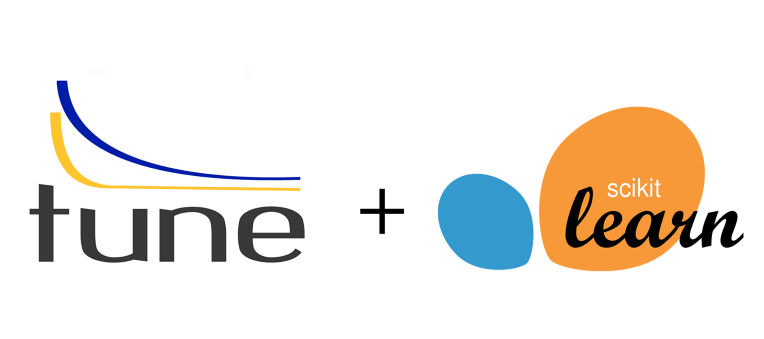

# Import modules
<hr style="border:2px solid black"> </hr>

In [21]:
from sklearn.model_selection import GridSearchCV
from tune_sklearn import TuneGridSearchCV, TuneSearchCV
import numpy as np
import time, scipy
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier

# Create a dataset
<hr style="border:2px solid black"> </hr>


- We choose the `SGDClassifier` because it has a `partial_fit` API, which enables it to stop fitting to the data for a certain hyperparameter configuration. 
- If the estimator does not support early stopping, we would fall back to a parallel grid search.



In [6]:
# Set training and validation sets
X, y = make_classification(n_samples=11000, n_features=1000, n_informative=50, 
                           n_redundant=0, n_classes=10, class_sep=2.5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1000)

In [7]:
X_train

array([[ 8.44244437e-02,  2.13374648e-01,  1.90207702e-01, ...,
        -8.36859908e-01,  9.75876609e-01, -1.25381756e+00],
       [-2.14590781e+00,  1.04629394e-03, -7.96553268e-01, ...,
        -1.49667463e-01, -1.27160690e+00,  9.80540431e-01],
       [-2.11579795e-01, -9.03071753e-01, -3.02202578e-02, ...,
         7.92725621e-01,  8.12404255e-01, -4.80202056e-01],
       ...,
       [-6.25558674e-01, -1.28465328e+00, -6.90960381e-02, ...,
         9.59553639e-01, -9.73088452e-01, -1.11426001e+00],
       [-1.65922784e-01, -2.88112452e-01,  3.07423934e-01, ...,
         2.50094704e+00, -8.41721156e-01,  3.44256769e-01],
       [ 8.05749058e-01,  9.31586750e-01, -2.63731284e-01, ...,
        -4.79440426e-01, -1.76393385e-01, -1.44529737e+00]])

# Tune-sklearn TuneGridSearchCV
<hr style="border:2px solid black"> </hr>

In [8]:
# Example parameters to tune from SGDClassifier
parameters = {
   'alpha': [1e-4, 1e-1, 1],
   'epsilon':[0.01, 0.1]
}


- Compare to scikit-leanr these are the new parameters:
    - a new `early_stopping` variable, and
    - a specification of `max_iters` parameter. It is the maximum number of iterations a given hyperparameter set could run for; it may run for fewer iterations if it is early stopped.



In [16]:
tune_search = TuneGridSearchCV(
    SGDClassifier(),
    parameters,
    early_stopping = True,
    max_iters = 10
)

In [17]:
start = time.time()
tune_search.fit(X_train, y_train)
end = time.time()
print("Tune-sklearn Fit Time:", end - start)
pred = tune_search.predict(X_test)
accuracy = np.count_nonzero(np.array(pred) == np.array(y_test)) / len(pred)
print("Tune-sklearn Accuracy:", accuracy)

File descriptor limit 256 is too low for production servers and may result in connection errors. At least 8192 is recommended. --- Fix with 'ulimit -n 8192'


Tune-sklearn Fit Time: 20.33966898918152
Tune-sklearn Accuracy: 0.859


# Sk-learn GridSearchCV
<hr style="border:2px solid black"> </hr>


- **n_jobs=-1** enables use of all cores like Tune does, so the comparison is fair.



In [13]:
sklearn_search = GridSearchCV(
   SGDClassifier(),
   parameters,
   n_jobs=-1
)

In [14]:
start = time.time()
sklearn_search.fit(X_train, y_train)
end = time.time()
print("Sklearn Fit Time:", end - start)
pred = sklearn_search.predict(X_test)
accuracy = np.count_nonzero(np.array(pred) == np.array(y_test)) / len(pred)
print("Sklearn Accuracy:", accuracy)

Sklearn Fit Time: 69.48267698287964
Sklearn Accuracy: 0.861


# TuneSearchCV Bayesian Optimization
<hr style="border:2px solid black"> </hr>


- Note the use of tuples instead if Bayesian optimization is desired.



In [31]:
param_dists = {
   'alpha': (1e-4, 1e-1),
   'epsilon': (1e-2, 1e-1)
}

In [32]:
tune_search_Bayesian = TuneSearchCV(SGDClassifier(),
   param_distributions = param_dists,   
   early_stopping = True,
   max_iters = 10,
   search_optimization = "bayesian"
)

In [33]:
start = time.time()
tune_search_Bayesian.fit(X_train, y_train)
end = time.time()
print("Tune Sklearn Bayesian Fit Time:", end - start)


File descriptor limit 256 is too low for production servers and may result in connection errors. At least 8192 is recommended. --- Fix with 'ulimit -n 8192'


Tune Sklearn Bayesian Fit Time: 22.23653292655945


In [34]:
print(tune_search.best_params_) 

{'alpha': 0.1, 'epsilon': 0.01}


In [36]:
pred = tune_search_Bayesian.predict(X_test)
accuracy = np.count_nonzero(np.array(pred) == np.array(y_test)) / len(pred)
print("Tune-sklearn Baysian Accuracy:", accuracy)

Tune-sklearn Baysian Accuracy: 0.858


# Conclusions
<hr style="border:2px solid black"> </hr>


- Sklearn has the best accuracy but has the highest tuning time.
- Tune sklearn has an accuracy slitghly lower but using only 1/3 of the time used up by sklearn.
- It is expected that depending on the test case this numbers will change.



# References
<hr style="border:2px solid black"> </hr>


- https://medium.com/distributed-computing-with-ray/gridsearchcv-2-0-new-and-improved-ee56644cbabf

